# PoseNet 2D to Kinect 2D

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
posenetDataPath = '../../datasets/posenet-uncut/'
kinectDataPath = '../../datasets/kinect_good_preprocessed_not_cut/'

X = None
y = None

train_test_ratio = 0.8
random_state = 47

# Model parameters
learning_rate = 0.001
optimizer = 'Adam'
loss = 'mse'
metrics = ['mae']
epochs = 500
batch_size = 16
layers = [ 
    { 'type': 'Dense', 'nodes':64, 'activation': 'relu' },
    { 'type': 'Dense', 'nodes':64, 'activation': 'relu' },
    { 'type': 'Dense', 'nodes':26, 'activation': ''}
]

# Early stopping parameters
monitor = 'val_loss'
verbose = 1
patience = 20
mode = 'min'
restore_best_weights = True

In [4]:
np.random.seed(random_state)

## 1. Data Preparation

### Load matching files from PoseNet and Kinect

In [5]:
import re

for file in os.listdir(posenetDataPath):
    if file.endswith('.csv'):
        try:
            posenetData = pd.read_csv(posenetDataPath + file)
            kinectData = pd.read_csv(kinectDataPath + '{}_kinect.csv'.format(file.replace('.csv', '')))
            # Check amount of frames
            if (len(posenetData) == len(kinectData)):
                posenetData.drop(columns=['FrameNo'], inplace=True)
                if X is None:
                    X = posenetData
                else:
                    X = pd.concat((X, posenetData), ignore_index=True)

                # Drop Z-columns from Kinect
                z = []
                for c in kinectData.columns:
                    if re.search("^.*_z$", c):
                        z.append(c)
                kinectData.drop(columns=z, inplace=True)
                kinectData.drop(columns=['FrameNo'], inplace=True)
                if y is None:
                    y = kinectData
                else:
                    y = pd.concat((y, kinectData), ignore_index=True)
        except IOError as e:
            print('Error in reading file: ', e)

print(X.shape)
print(y.shape)

(30502, 26)
(30502, 26)


### Training and test split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=train_test_ratio, random_state=random_state)

input_dim = X_train.shape[1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24401, 26)
(24401, 26)
(6101, 26)
(6101, 26)


### Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)

## 2. DL Model

### Layer Factory

In [8]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten

def layerFactory(type, nodes, activation):
    if type == 'Dense':
        if not activation:
            return Dense(units=nodes)
        else:
            return Dense(units=nodes, activation=activation)
    if type == 'Conv1D':
        if not activation:
            return Conv1D(units=nodes)
        else:
            return Conv1D(units=nodes, activation=activation)
    if type == 'MaxPooling1D':
        if not activation:
            return MaxPooling1D(units=nodes)
        else:
            return MaxPooling1D(units=nodes, activation=activation)
    if type == 'Dropout':
        if not activation:
            return Dropout(units=nodes)
        else:
            return Dropout(units=nodes, activation=activation)
    if type == 'Flatten':
        if not activation:
            return Flatten(units=nodes)
        else:
            return Flatten(units=nodes, activation=activation)
    
    # otherwise return dense as default
    return Dense(units=nodes, activation=activation)

### Model Architecture

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

model = Sequential([
    InputLayer(input_shape=(input_dim))
])

for layer in layers:
    model.add(layerFactory(layer['type'], layer['nodes'], layer['activation']))

optimizer = tf.keras.optimizers.get(optimizer)
optimizer.learning_rate.assign(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1728      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 26)                1690      
Total params: 7,578
Trainable params: 7,578
Non-trainable params: 0
_________________________________________________________________


### Early stopping

In [10]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor=monitor, 
    verbose=verbose,
    patience=patience,
    mode=mode,
    restore_best_weights=restore_best_weights)

### Model Training

In [11]:
history = model.fit(x=X_train, y=y_train, validation_split=0.2, shuffle=True, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=[early_stopping])

training_history = pd.DataFrame(history.history)
training_history['epochs'] = range(len(training_history['mae']))

Epoch 1/500
1220/1220 [==============================] - 1s 860us/step - loss: 0.3651 - mae: 0.3924 - val_loss: 0.1322 - val_mae: 0.2432
Epoch 2/500
1220/1220 [==============================] - 1s 694us/step - loss: 0.1346 - mae: 0.2403 - val_loss: 0.1121 - val_mae: 0.2246
Epoch 3/500
1220/1220 [==============================] - 1s 711us/step - loss: 0.1171 - mae: 0.2231 - val_loss: 0.0941 - val_mae: 0.2072
Epoch 4/500
1220/1220 [==============================] - 1s 698us/step - loss: 0.1018 - mae: 0.2116 - val_loss: 0.0869 - val_mae: 0.1989
Epoch 5/500
1220/1220 [==============================] - 1s 702us/step - loss: 0.0923 - mae: 0.2030 - val_loss: 0.0943 - val_mae: 0.2021
Epoch 6/500
1220/1220 [==============================] - 1s 703us/step - loss: 0.0880 - mae: 0.1976 - val_loss: 0.0827 - val_mae: 0.1917
Epoch 7/500
1220/1220 [==============================] - 1s 705us/step - loss: 0.0830 - mae: 0.1907 - val_loss: 0.0796 - val_mae: 0.1912
Epoch 8/500
1220/1220 [==================

### Plot training and validation MAE & loss per epoch

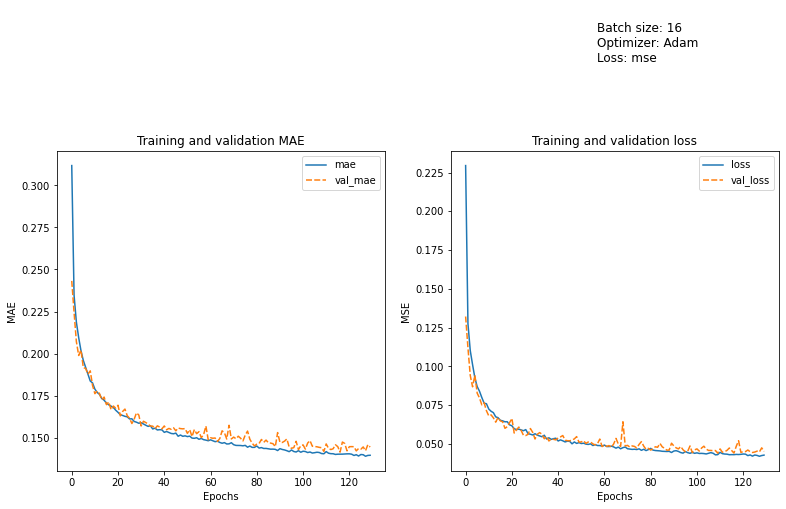

In [12]:
plots = [
           {'cols':['mae', 'val_mae'], 'title':'Training and validation MAE', 'yLabel':'MAE'},
           {'cols':['loss', 'val_loss'], 'title':'Training and validation loss', 'yLabel':'MSE'},
]

fig = plt.figure(figsize=(20,20))
fig_no = 331
title = '\nBatch size: {}\nOptimizer: {}\nLoss: {}'.format(batch_size,optimizer._name, loss)
fig.suptitle(title, fontsize="large", horizontalalignment='left', verticalalignment='top')

for i in range(len(plots)):
    ax = fig.add_subplot(str(fig_no))
    sns.lineplot(data=training_history[plots[i]['cols']], ax=ax)
    plt.title(plots[i]['title'])
    plt.xlabel('Epochs')
    plt.ylabel(plots[i]['yLabel'])
    fig_no += 1

plt.show()

### Predictions

In [13]:
# Invert transform on predictions
predictions = model.predict(X_test, verbose=1)
predictions = y_scaler.inverse_transform(predictions)

191/191 [==============================] - 0s 448us/step


In [14]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

print('MSE: ', mean_squared_error( y_test, predictions ))
print('MSA: ', mean_absolute_error( y_test, predictions ))
print('R-Squared: ', r2_score( y_test, predictions ))
print('Explained Variance Score: ', explained_variance_score( y_test, predictions ))

MSE:  0.0008848011187325323
MSA:  0.018191355000340626
R-Squared:  0.9559150680476047
Explained Variance Score:  0.9561264155706753
